## Import Packages

In [1]:
import os
import sys
import numpy as np
import errno

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from looti  import tools as too
import pandas as pd
import random as rn
from itertools import cycle
import time
from collections import OrderedDict

In [2]:
from looti import emulatorpaths as epath

#from looti  import tools as too
from looti  import interpolators as itp

from looti import dataplotters as dtp

from looti import dictlearn as dcl

from looti import datahandle as dhl

#sns.set()

In [3]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
def RMSE(test_vector,test_prediction): ## must be changed now
    RMSE = too.root_mean_sq_err(test_prediction, test_vector)
    return RMSE

def plot_RMSE(train_size_max,wanted_ntest=1): ## must be changed now
    RMSE_vals = []
    for i in range(0,train_size_max):
        emulation_data.calculate_data_split(n_train=i , n_test = wanted_ntest, 
                                        n_splits=1, verbosity=3,num_percentiles=3)
        emulation_data.data_split(0)
        npca = emulation_data.train_size

        PCAop = dcl.LearningOperator('PCA', ncomp=npca, interp_type='int1d')
        intobj = dcl.LearnData(PCAop)

    intobj.interpolate(train_data=(emulation_data.matrix_datalearn_dict["theo"]['train']-mean)/sigma,
                           train_samples=emulation_data.train_samples)
        ratios_predicted=intobj.predict(emulation_data.test_samples);
        RMSE_test=0
        for i,test_samples in enumerate(emulation_data.test_samples):
            paramvalue=test_samples
            test_vector =emulation_data.matrix_datalearn_dict["theo"]["test"][i].flatten()
            RMSE_test+=RMSE( test_vector, ratios_predicted[test_samples])
        RMSE_test/emulation_data.test_size
        RMSE_vals.append(RMSE_test)
    plt.plot([k for k in range(2,train_size_max+2)],RMSE_vals)
    return RMSE_vals

def Plot_prediction(emulation_data, paramvalue_predicted, ratios_predicted) :
    if emulation_data.masked_k_grid is not None:
        k_grid=np.power(10,emulation_data.masked_k_grid)
    else:
        k_grid=emulation_data.lin_k_grid

    
    ratio_train_dict=dict(zip(emulation_data.train_samples,emulation_data.matrix_datalearn_dict["theo"]["train"]))
    ratio_test_dict=dict(zip(emulation_data.test_samples,emulation_data.matrix_datalearn_dict["theo"]["test"]))
    
    
    paramvalue = paramvalue_predicted
    fig,ax =plt.subplots(2, figsize=(10,8), dpi=200,facecolor='w')
    for tt in emulation_data.train_samples:

        ax[0].semilogx(k_grid,ratio_train_dict[tt],'-o', color='blue', lw=1, ms=1, markevery=1, 
             alpha=0.8, label="Training Ratio param = "+str(tt))


    ax[0].semilogx(k_grid,ratio_test_dict[paramvalue],'-v', color='red', lw=1, ms=1, markevery=1, 
             alpha=0.8, label="Actual Ratio param = "+str(paramvalue))
    ax[0].semilogx(k_grid,ratios_predicted[paramvalue],'-s', color='green', lw=1, ms=2, markevery=1, 
             alpha=0.8, label="Predicted Ratio param = "+str(paramvalue))


    ax[0].legend(loc='upper left')
    #plt.plot(kgrid_cod,emu_beta_EXP_codec/powerLCDM_cod)
    #plt.xscale('log')

    ax[1].semilogx(k_grid,1-ratios_predicted[paramvalue]/ratio_test_dict[paramvalue],'-v', 
               color='purple', lw=1, ms=1, markevery=1, 
         alpha=0.8, label="Ratio of Ratios param = "+str(paramvalue))


# Run Parameters

## Import Data

The data correspond to the frames containing the power matter spectrum or ratios at different redshift and for different parameters. These frames have a standard format that can be automatically constructed with the notebook read_files.

The data must be organised in the following way :
- One folder containing the whole data : datafolder
- One input folder contaning the input data : power matter spectrum/ratios. Usually there is two files one containing the LCDM p_ks as a reference, and one containing the p_ks of experiments e.g CDE, F(R), MassivNus
- One output folder that will containing the results (plots) of the predictions


In [5]:
###Folder containing the data
datafolder = '../../optimaltransport/'

###Folder containing the input data
inputfolder=datafolder+'codecs_ratios/'

###Folder containing the output data
outputfolder=datafolder+'codecs_interpolations/'

The user must provide : 
- datafile_ext : the file's name containing the power spectrum/ratios of (CDE,F(R),MassivNus,...)
- datafile_lc : the file's name containing the power spectrum/ratios of LCDM which will be taken as a reference

In [6]:
###Name of the file for the external input data
datafile_exp = 'EXP_Pk_26_betas_33_redzs'
print(datafile_exp)

###Name of the file for the LCDM input data
datafile_lc = 'LCDM_Pk_33_redzs'
print(datafile_lc)

EXP_Pk_26_betas_33_redzs
LCDM_Pk_33_redzs


## Obtain Data Matrix

User should change : 
- ratio_mode : True means that ratios are directly provided. If False, the ratios will be computed by dividing the features from datafile_ext by datafile_lc
- param_names_dict : The names of the parameters as a dictionnary 
- multindex_cols_ext : the columns of the frame containing the index. The minimum is [0,1,2,3] for : noise_level, redshift, parameter_1 name, parameter_1 values.

In [7]:
emulation_data = dhl.DataHandle( datafile_exp,inputfolder,datafile_lc,multindex_cols_ref=[0,1])
emulation_data.read_csv_pandas()



Shape of imported reference model dataframe:  (100, 1099)
Shape of imported extended model dataframe:  (2575, 1099)


Ratios are computed at a given redshift. User should provide, the redshift chosen.
The function calculate_ratio_data will compute the ratios at this redshift : datafile_ext/datafile_lc.
If ratios_mode = True : datafile is directly used to obtains the ratios.

In [8]:
###Redshfit 
zchoice=0.1
#Calculate the ratio
emulation_data.calculate_ratio_data(zchoice)

If the user wants to apply a mask : GLOBAL_applymask = True


In [9]:
linkgrid = np.power(10, emulation_data.k_grid)
mask = np.where(linkgrid >0.1)[0]
GLOBAL_applymask = True
thinning = 5 

## Run parameters and split the data

User should change the number of training vectors, wanted test vector. If cross-validation is wanted, number_of_spltis should be greater that one. 

In [10]:
max_ntrain = 10
wanted_ntest = 5  ## number of test vectors, that will be fixed, red
number_of_splits = 1   # number of random data splits

The user should not change anything here except verbosity. 
- calculate_data_split will find the indexes of train,validation and test vectors.
- data_split will split the data into train,validation and test vectors by using the indexes calculated before.

If the number of training vectors + number of test vectors is equals to the number of samples then there will be no validation vectors.

In [11]:
emulation_data.calculate_data_split(n_train=max_ntrain, n_test=wanted_ntest , 
                                    n_splits=number_of_splits, verbosity=0,num_percentiles=1)
emulation_data.data_split(split_index=0,thinning=thinning, mask=mask, 
                                              apply_mask=GLOBAL_applymask, verbosity=0);

# PCA Example

User should provide here the number of components. The following code will create the interpolator object, perfom PCA, interpolate the training data and predict the values of the test samples

Choose the number of PCA components

In [12]:
npca = 2

Perfom PCA and interpolation then predict

In [13]:
noi="theo" ###Level of noise
PCAop = dcl.LearningOperator('PCA', ncomp=npca, interp_type='int1d')
intobj = dcl.LearnData(PCAop)
intobj.interpolate(train_data=emulation_data.matrix_datalearn_dict[noi]['train'],
                           train_samples=emulation_data.train_samples)
ratio_predicted = intobj.predict(emulation_data.test_samples);

('Shape of PCA matrix: (12, 2)',)
('Number of PCA components: 2',)


 global mean min error:  1.1788482315597805e-05 
 global mean max error:  0.0007687502219880802 
 global max rmse:  0.0005054418487477166 
 global mean rmse:  0.0003776166060957181 
 global var rmse:  1.652775089820961e-08


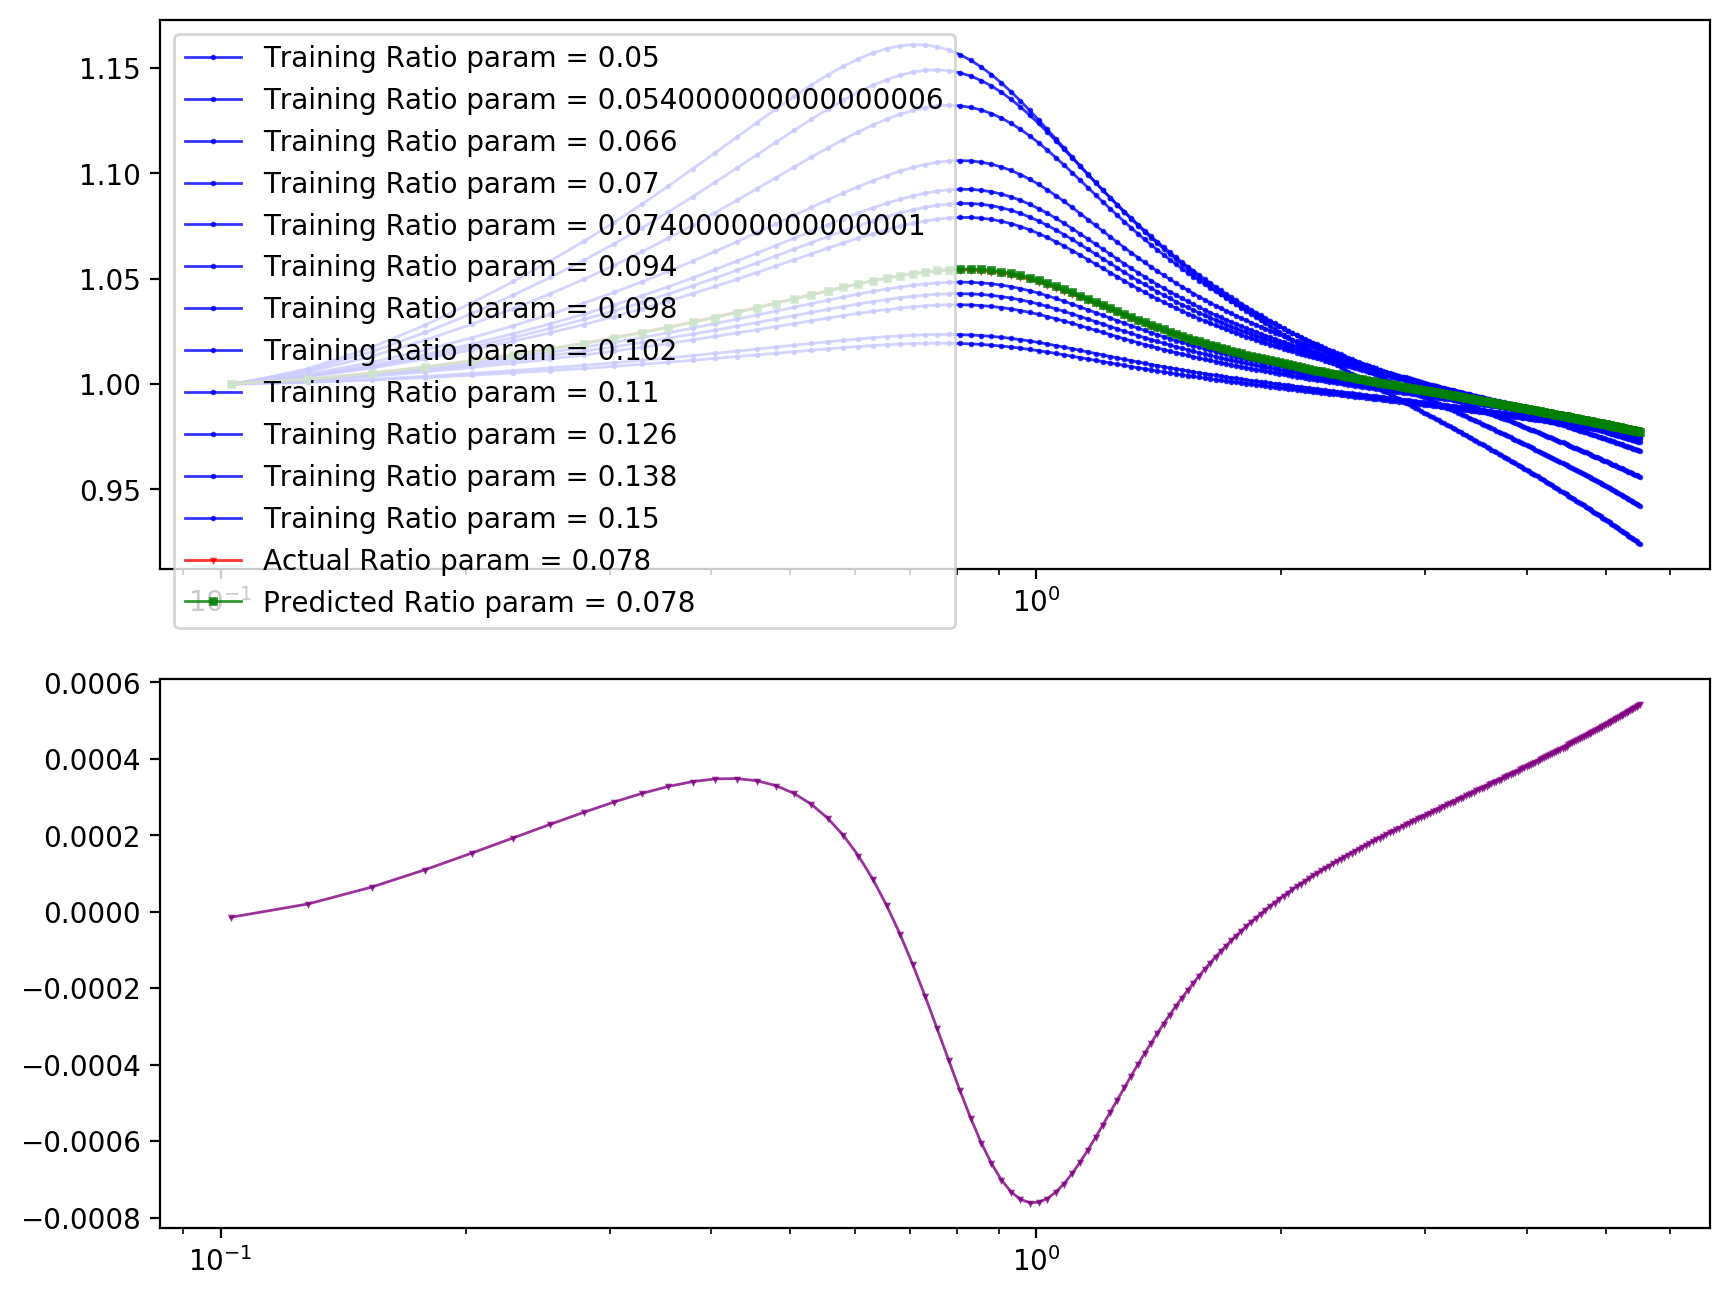

In [14]:
Plot_prediction(emulation_data,emulation_data.test_samples[0], ratio_predicted)

intobj.calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                            emulation_data.test_samples)
intobj.print_statistics()


('number of wanted training vectors', 0)
('number of wanted test vectors', 8)
('number of obtained training vectors', 2)
('number of obtained validation vectors', 16)
('Shape of PCA matrix: (2, 2)',)
('Number of PCA components: 2',)
('number of wanted training vectors', 1)
('number of wanted test vectors', 8)
('number of obtained training vectors', 3)
('number of obtained validation vectors', 15)
('Shape of PCA matrix: (3, 3)',)
('Number of PCA components: 3',)
('number of wanted training vectors', 2)
('number of wanted test vectors', 8)
('number of obtained training vectors', 4)
('number of obtained validation vectors', 14)
('Shape of PCA matrix: (4, 4)',)
('Number of PCA components: 4',)
('number of wanted training vectors', 3)
('number of wanted test vectors', 8)
('number of obtained training vectors', 5)
('number of obtained validation vectors', 13)
('Shape of PCA matrix: (5, 5)',)
('Number of PCA components: 5',)
('number of wanted training vectors', 4)
('number of wanted test vec

[0.09157915898665574,
 0.07406677893061941,
 0.05091098097389028,
 0.025988411206571364,
 0.025988411206571374,
 0.012321753939651714,
 0.012321753939651823,
 0.011942390707915574,
 0.01194239070791552,
 0.004158146033552358,
 0.0023994058699284672,
 0.0022599929761028944,
 0.0021948105946724282,
 0.0021323351373896088,
 0.0013537093550710496,
 0.0012058963280606573]

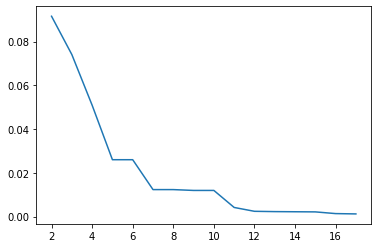

In [15]:
###Plot RMSE(number of training vector,number of test vectors)
plot_RMSE(16,8) 

# GP Example

In [16]:
mean = np.mean(emulation_data.matrix_ratios_dict["theo"])
sigma = np.std(emulation_data.matrix_ratios_dict["theo"])

Here I used mean and sigma to normalize the data in order to allow the convergence of the lbfgs

('number of wanted test vectors', 5)
('number of obtained training vectors', 6)
('number of obtained validation vectors', 15)
 global mean min error:  0.00964618628859909 
 global mean max error:  1.9866773049216697 
 global max rmse:  1.8316163934196115 
 global mean rmse:  1.2016026140757035 
 global var rmse:  0.4058539522792395


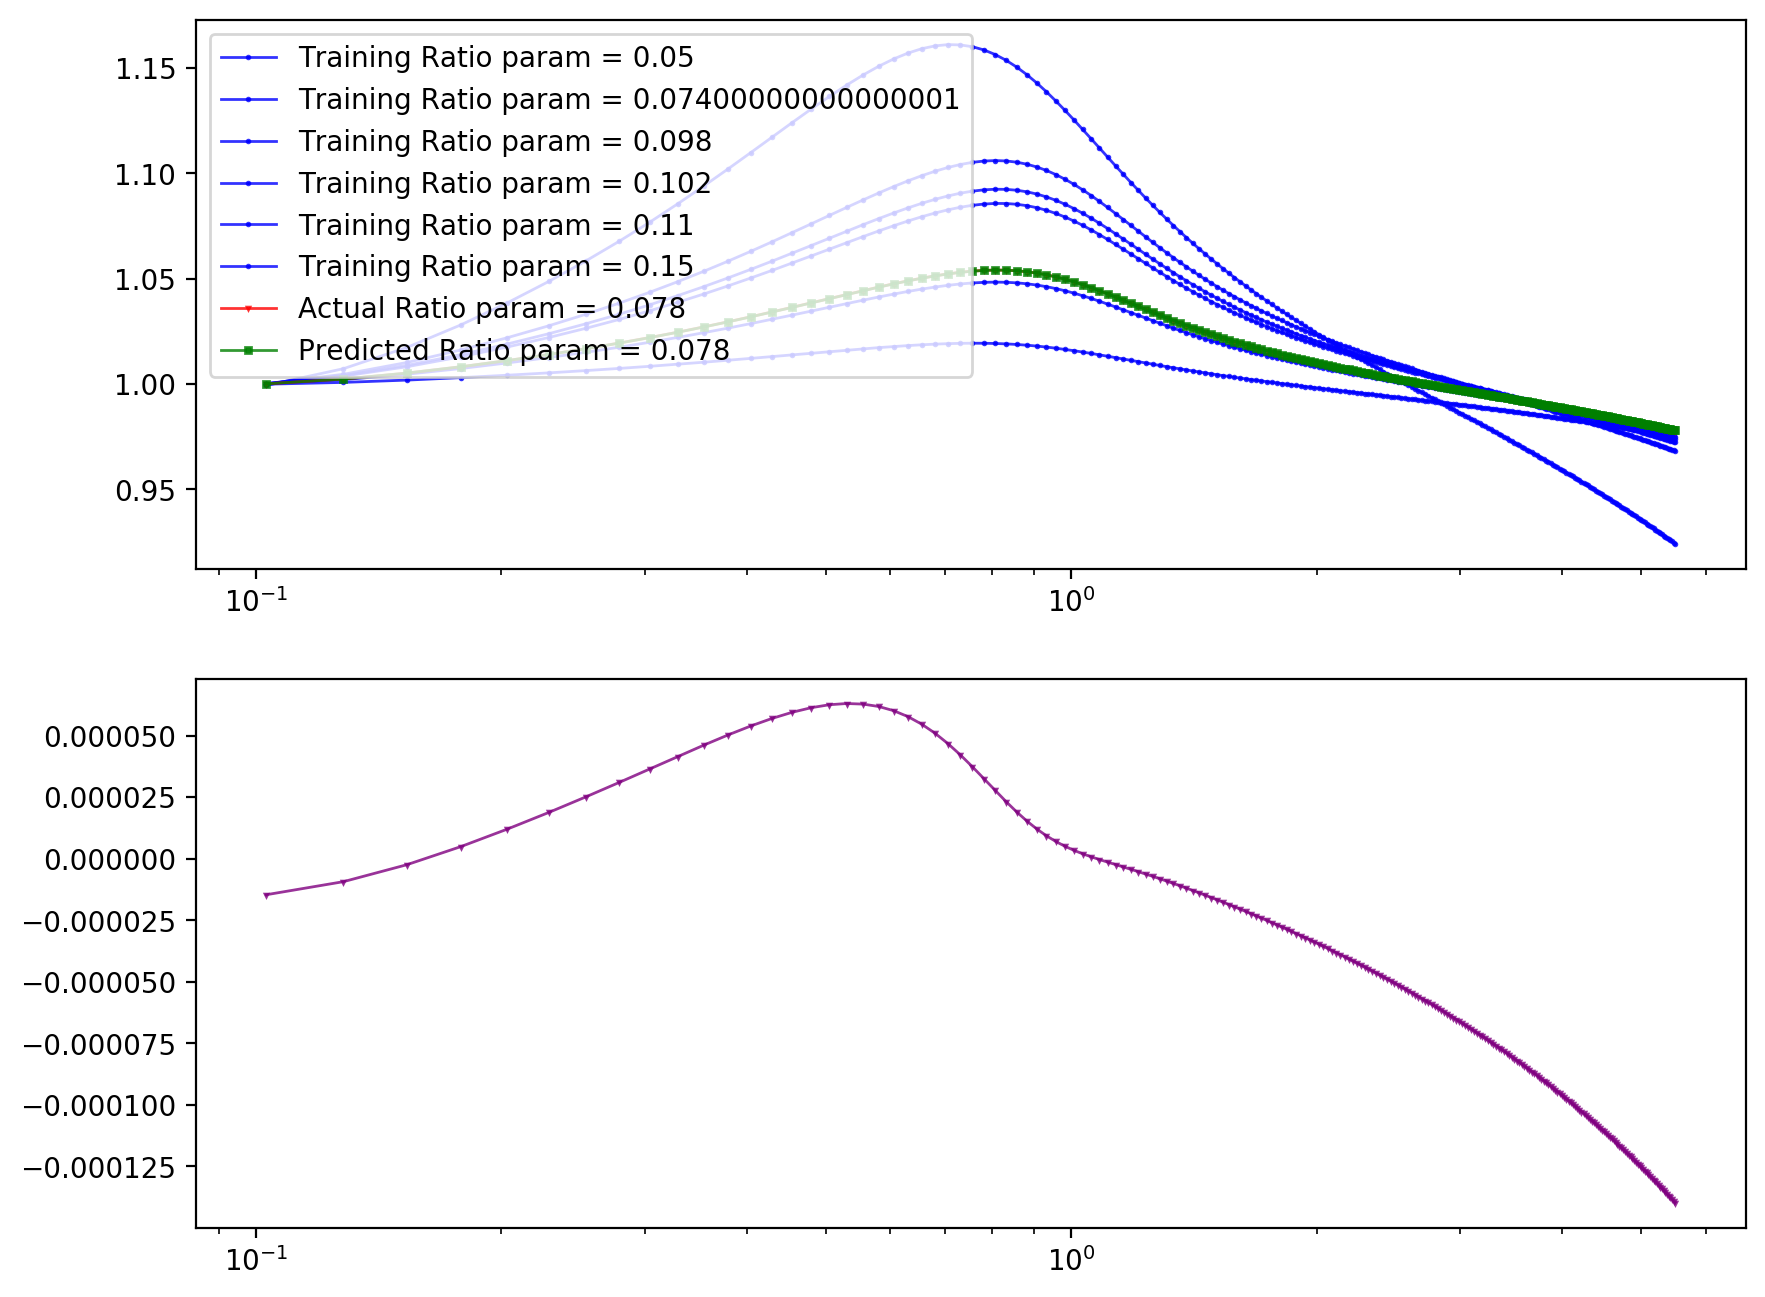

In [18]:
emulation_data.calculate_data_split(n_train=4 , n_test = wanted_ntest, 
                                    n_splits=number_of_splits , verbosity=1,num_percentiles=1)

emulation_data.data_split(split_index=0,thinning=thinning, mask=mask, 
                                              apply_mask=GLOBAL_applymask, verbosity=1)
GPop = dcl.LearningOperator('GP')
intobj = dcl.LearnData(GPop)

###Perfoming the PCA reduction and interpolation 
intobj.interpolate(train_data=(emulation_data.matrix_datalearn_dict["theo"]['train']-mean)/sigma,
                           train_samples=emulation_data.train_samples)
###Predicting the ratio with the inpolations :

ratios_predicted = intobj.predict(emulation_data.test_samples);
###Simple dictionnary to match parameters respecting to their ratio.

ratios_predicted[emulation_data.test_samples[0]]=ratios_predicted[emulation_data.test_samples[0]]*sigma+mean
Plot_prediction(emulation_data, emulation_data.test_samples[0],ratios_predicted)

intobj.calc_statistics(emulation_data.matrix_datalearn_dict.theo['test'],
                                            emulation_data.test_samples)
intobj.print_statistics()

In [22]:
D={}
print(1 in D.keys()  )
D[1]=2
print(1 in D.keys() )

False
True
